In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os

In [3]:
full_df = pd.read_csv("series_data.csv", low_memory=False)
image_output_directory = "./images"
table_output_directory = "./tables"

os.makedirs(image_output_directory, exist_ok=True)
os.makedirs(table_output_directory, exist_ok=True)

full_df.head()

In [ ]:
def get_dataset(tags):
    if "DFire" in tags:
        return "DFire"
    elif "CityscapesFine" in tags:
        return "Cityscapes"
    elif "CIFAR10" in tags:
        return "CIFAR10"
    else:
        raise ValueError(f"Unknown dataset: {tags}")

In [ ]:
def get_purpose(tags):
    if "Method" in tags:
        return "Method"
    elif "Baseline" in tags:
        return "Baseline"
    elif "Standard" in tags:
        return "Standard"
    else:
        raise ValueError(f"Unknown method: {tags}")

In [ ]:
full_df["dataset"] = full_df["tags"].apply(lambda x: get_dataset(x))
full_df["timestamp"] = pd.to_datetime(full_df["timestamp"])
full_df["purpose"] = full_df["tags"].apply(lambda x: get_purpose(x))

standard_trains = full_df[full_df["method"].isna()]
citl_trains = full_df[~full_df["method"].isna()]
assert len(standard_trains) + len(citl_trains) == len(full_df)

full_df.head()

,step,value,timestamp,namespace,metric,run_id,tags,alpha,control_on_realized,lr,lr_method,method,num_classes,selectively_backpropagate,val_alpha,dataset,purpose
0,594.0,1.0,2024-08-10 19:58:30.322,training,Train Dataset Size,CITL-111,"['efficientnet-b0', 'complete', 'Method', 'Cit...",0.1,False,0.0005,plateau,score,20,True,0.1,Cityscapes,Method
1,1189.0,1.0,2024-08-10 20:01:40.743,training,Train Dataset Size,CITL-111,"['efficientnet-b0', 'complete', 'Method', 'Cit...",0.1,False,0.0005,plateau,score,20,True,0.1,Cityscapes,Method
2,1784.0,1.0,2024-08-10 20:04:51.586,training,Train Dataset Size,CITL-111,"['efficientnet-b0', 'complete', 'Method', 'Cit...",0.1,False,0.0005,plateau,score,20,True,0.1,Cityscapes,Method
3,2379.0,1.0,2024-08-10 20:08:02.505,training,Train Dataset Size,CITL-111,"['efficientnet-b0', 'complete', 'Method', 'Cit...",0.1,False,0.0005,plateau,score,20,True,0.1,Cityscapes,Method
4,2974.0,1.0,2024-08-10 20:11:12.949,training,Train Dataset Size,CITL-111,"['efficientnet-b0', 'complete', 'Method', 'Cit...",0.1,False,0.0005,plateau,score,20,True,0.1,Cityscapes,Method


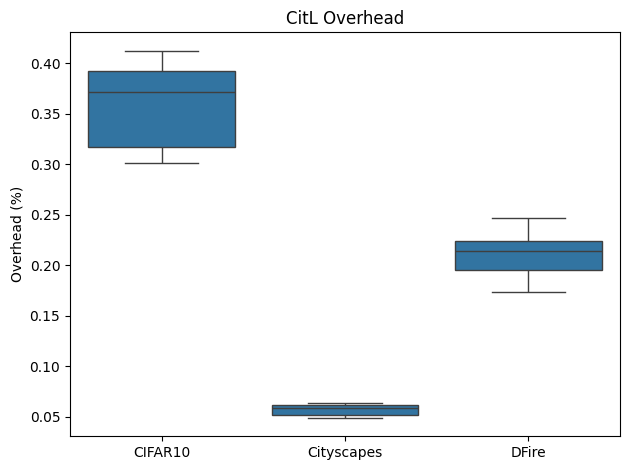

In [ ]:
### OVERHEAD
standard_times = standard_trains.groupby(by=["dataset"]).agg({"timestamp": ['max', 'min'], "step": "max"})
standard_times["duration"] = (standard_times["timestamp"]["max"] - standard_times["timestamp"]["min"]).dt.total_seconds()
standard_times["steps_per_second"] = standard_times["step"]["max"] / standard_times["duration"]

citl_times = citl_trains.groupby(by=["run_id", "dataset"]).agg({"timestamp": ['max', 'min'], "step": "max"})
citl_times["duration"] = (citl_times["timestamp"]["max"] - citl_times["timestamp"]["min"]).dt.total_seconds()
citl_times["steps_per_second"] = citl_times["step"]["max"] / citl_times["duration"]

joined_times = pd.merge(standard_times, citl_times, on="dataset", suffixes=("_standard", "_citl"))
joined_times["overhead"] = (joined_times["steps_per_second_standard"] / joined_times["steps_per_second_citl"]) - 1
joined_times = joined_times.reset_index()
box_plot = sns.boxplot(data=joined_times, x="dataset", y="overhead")
ax = box_plot.axes
plt.title("CitL Overhead")
plt.ylabel("Overhead (%)")
plt.xlabel(None)
plt.tight_layout()
plt.savefig(f'{image_output_directory}/overhead.png', dpi=300, bbox_inches='tight')

joined_times.groupby(by=["dataset"])["overhead"].agg(["mean", "std", "min", "max"]).to_latex(f"{table_output_directory}/overhead.tex")

In [ ]:
test_metrics = citl_trains[citl_trains["metric"].str.startswith('test_')]

baseline_metrics = test_metrics[test_metrics["purpose"] == "Baseline"]
method_metrics = test_metrics[test_metrics["purpose"] == "Method"]

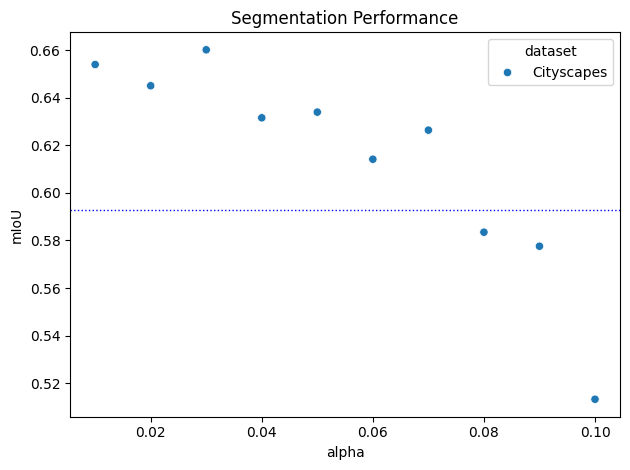

In [ ]:
baseline_segmentation_metrics = baseline_metrics[baseline_metrics["dataset"] == "Cityscapes"]

method_segmentation_metrics = method_metrics[method_metrics["dataset"] == "Cityscapes"]

baseline_segmentation_metrics = baseline_segmentation_metrics.pivot(index=["run_id"], columns="metric", values=["value"])
baseline_segmentation_metrics.columns = [col[1] if col[1] else col[0] for col in baseline_segmentation_metrics.columns]

method_segmentation_metrics = method_segmentation_metrics.pivot(index=["run_id", "alpha", "dataset"], columns="metric", values=["value"]).reset_index().sort_values("alpha")
method_segmentation_metrics.columns = [col[1] if col[1] else col[0] for col in method_segmentation_metrics.columns ]

sns.scatterplot(data=method_segmentation_metrics, x="alpha", y="test_jaccard", hue="dataset")
plt.axhline(y=baseline_segmentation_metrics.iloc[0]["test_jaccard"], color='b', linestyle=':', linewidth=1)
plt.ylabel("mIoU")
plt.title("Segmentation Performance")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/segmentation_performance.png', dpi=300, bbox_inches='tight')


In [ ]:
baseline_classification_metrics = baseline_metrics[baseline_metrics["dataset"] != "Cityscapes"]
method_classification_metrics = method_metrics[method_metrics["dataset"] != "Cityscapes"]

method_classification_metrics = method_classification_metrics.pivot(index=["run_id", "alpha", "dataset"], columns="metric", values=["value"]).reset_index().sort_values("alpha")
method_classification_metrics.columns = [col[1] if col[1] else col[0] for col in method_classification_metrics.columns ]

sns.scatterplot(data=method_classification_metrics, x="alpha", y="test_accuracy", hue="dataset")
plt.axhline(y=method_classification_metrics[method_classification_metrics["dataset"] == "CIFAR10"].iloc[0]["test_accuracy"], color='b', linestyle=':', linewidth=1)
plt.axhline(y=method_classification_metrics[method_classification_metrics["dataset"] == "DFire"].iloc[0]["test_accuracy"], color='orange', linestyle=':', linewidth=1)
plt.ylabel("Accuracy")
plt.title("Classification Performance")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/classification_performance.png', dpi=300, bbox_inches='tight')


NameError: name 'baseline_metrics' is not defined